In [1]:
%load_ext sql

# Connect to CHINOOK database

Conect directly from sqlite folder

In [2]:
%sql sqlite:///C:/sqlite/chinook.db

In [3]:
%%sql
PRAGMA table_info(invoice_line);

 * sqlite:///C:/sqlite/chinook.db
Done.


cid,name,type,notnull,dflt_value,pk
0,invoice_line_id,INTEGER,1,None,1
1,invoice_id,INTEGER,1,None,0
2,track_id,INTEGER,1,None,0
3,unit_price,"NUMERIC(10,2)",1,None,0
4,quantity,INTEGER,1,None,0


# 1) Introduction

In this lesson, we'll go a step further to learn some new skills:

* How to aggregate a table by group according to several criteria

* How to filter aggregated columns with the `HAVING` clause

# 2) Grouping over Several Columns

We reviewed how to group rows with a given criterion using the GROUP BY clause in the introduction. Sometimes, we want to group rows by several criteria. 

For example, one can group sales by:

*  state and city,

*  country and city,

* country,

* state,

*  and city.

When you're using only one criterion, there are as many groups as there are distinct values in the grouping column. When you're using more than one criterion, it's the combination of all the grouping columns that must be distinct. 

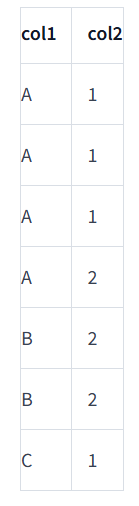

The distinct values in `col1` are A, B, and C. Those in `col2` are 1 and 2. 

The possible distinct combinations are A1, A2, B1, B2, C1, and C2. However, since the combinations B1 and C2 don't exist in our table, they don't appear in the result.

We write the following query to count the rows and compute the average total purchase amount per **country and city** in the `invoice` table.

```sql
SELECT billing_country, billing_city, COUNT(*) AS num_row, AVG(total) AS avg_sale 
  FROM invoice
 GROUP BY billing_country, billing_city;
 ```

## Instructions

1. Write a query that counts the rows and computes the average `total` purchase amount per country and state in the `total` column from the `invoice` table.

 * Count rows, and name the resulting column as `num_row`.

 * Compute the average total purchase amount and name the resulting column as `avg_sale`.

 * Group the rows by country and state using the `billing_country` and `billing_state` columns.

In [5]:
%%sql
SELECT billing_country,
       billing_state,
       COUNT(*) as num_row,
       AVG(total) as avg_sale
FROM invoice
GROUP BY billing_country, billing_state
limit 5;

 * sqlite:///C:/sqlite/chinook.db
Done.


billing_country,billing_state,num_row,avg_sale
Argentina,None,5,7.92
Australia,NSW,10,8.118
Austria,None,9,7.699999999999999
Belgium,None,7,8.627142857142857
Brazil,DF,15,7.128


# 3) Aggregate Queries with Non-Aggregate Result Columns

Let's review what we can do with aggregate functions.

We can use aggregate functions on the whole table. The **result is single-row** summary statistics.

```sql
SELECT COUNT(*) AS num_row, AVG(total) AS avg_sale
  FROM invoice;
```

We can use aggregate functions on the grouped-data. The **result is summary statistics for each group**.

```sql
SELECT billing_country, billing_state, COUNT(*) AS num_row, AVG(total) AS avg_sale 
  FROM invoice
 GROUP BY billing_country, billing_state;
```

As you might notice, in the first case, we **don't indicate any additional columns** other than the aggregate columns.

In the second case, we **indicate the columns of the GROUP BY clause plus the aggregated columns**. These are the standard use cases that will work in any database management systems (DBMS).

However, let's imagine for example, in the case of the previous query, that we want to also display the `billing_city` column even though it's neither an aggregated column nor a column present in the GROUP BY clause.

In [6]:
%%sql
SELECT billing_country, billing_state, billing_city, COUNT(*) AS num_row, AVG(total) AS avg_sale 
  FROM invoice
 GROUP BY billing_country, billing_state
 LIMIT 3;

 * sqlite:///C:/sqlite/chinook.db
Done.


billing_country,billing_state,billing_city,num_row,avg_sale
Argentina,None,Buenos Aires,5,7.92
Australia,NSW,Sidney,10,8.118
Austria,None,Vienne,9,7.699999999999999


We notice here that SQLite (our database management system) chose the **first column value** of the `billing_city` for each group while there are several others cities. 

For example, the result shows only Buenos Aires in Argentina. This is not a SQL standard behavior and represents a flexibility that SQLite allows. Therefore, it can change in other DBMSs. **It's been advised not to use non-aggregate columns in aggregate queries**.

# 4) Revisiting Possibilities with Aggregate Functions and other Clauses

since the `WHERE` clause runs before `GROUP BY`, we may wonder what happens if we want conditions on an aggregated column. For example, we want to display only **rows where the number of sales is greater than 40**. The expected result is this table:

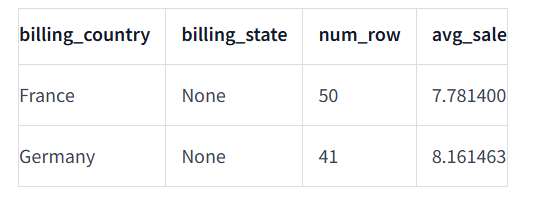

## Instructions

1. Copy and paste the previous exercise query, and edit it to filter the result only where `COUNT(*)` is greater than `40`.

    * Use the `WHERE` clause for this operation.

1. This query will generate an error, but it's the expected behavior.


In [7]:
%%sql
SELECT billing_country,
       billing_state,
       COUNT(*) as num_row,
       AVG(total) as avg_sale
FROM invoice
WHERE num_row > 40
GROUP BY billing_country, billing_state

 * sqlite:///C:/sqlite/chinook.db
(sqlite3.OperationalError) misuse of aggregate: COUNT()
[SQL: SELECT billing_country,
       billing_state,
       COUNT(*) as num_row,
       AVG(total) as avg_sale
FROM invoice
WHERE num_row > 40
GROUP BY billing_country, billing_state]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


# 5) Adding Conditions on an Aggregated Column: the Correct Way

This error means we are misusing the `COUNT` aggregate function. Since our query was working before we introduced the WHERE clause, this is the cause of the error.

The problem is that we were trying to use the `WHERE` clause on **an aggregated column**.

SQL proposes the `HAVING` clause, which is equivalent to the `WHERE` clause for aggregate functions, to overcome this problem.

To make our query work, we must replace the `WHERE` clause by `HAVING`.

In [8]:
%%sql
SELECT billing_country,
       billing_state,
       COUNT(*) as num_row,
       AVG(total) as avg_sale
FROM invoice
GROUP BY billing_country, billing_state
HAVING COUNT(*) > 40 
--colocar após o group by
-- Não é possível usar alias na cláusula HAVING

 * sqlite:///C:/sqlite/chinook.db
Done.


billing_country,billing_state,num_row,avg_sale
France,None,50,7.7814
Germany,None,41,8.161463414634147


# 6) Revisiting the Order of Execution

Now, we can introduce the HAVING clause after GROUP BY in the order of clauses:

> SELECT > FROM > WHERE > GROUP BY > HAVING > ORDER BY > LIMIT

Instead the order of execution is as follows:

> FROM > WHERE > GROUP BY > HAVING > SELECT > ORDER BY > LIMIT

The **order of execution** is the most important thing here because the `HAVING` clause **can't exist without aggregate function** and the `GROUP BY` clause. Here are two things to remember about the order of execution:

 * SQL **always filters** the rows with the `HAVING` clause **after grouping** rows while it filters the rows with the `WHERE` clause **before grouping rows**.

 * `HAVING` is **always used with the GROUP BY** clause and is always placed just after it.

# 7) Adding Conditions on Not-Displayed Aggregate Column

Basically, when writing `HAVING COUNT(*) > 40`, SQL first computes the summary statistics before the filtering. We can filter aggregated columns according to a summary statistic that isn't displayed.

For example, the following query will display the same table as before without the column `num_row`:

```sql
SELECT billing_country, billing_state, AVG(total) AS avg_sale 
  FROM invoice
 GROUP BY billing_country, billing_state
HAVING COUNT(*) > 40;
```

## Instructions

1. Write a query that, for each country and state, computes the `minimum` and `maximum` total purchase amount **when the average total purchase amount is lower than $10**. Display the following columns in your result:

Billing country

Billing state

Minimum total purchase amount as `min_sale`

Maximum total purchase amount as `max_sale`

In [11]:
%%sql
SELECT billing_country,
       billing_state,
       MIN(total) as min_sale,
       MAX(total) as max_sale
FROM invoice
GROUP BY billing_country, billing_state
HAVING AVG(total) < 10
limit 5;

 * sqlite:///C:/sqlite/chinook.db
Done.


billing_country,billing_state,min_sale,max_sale
Argentina,None,0.99,12.87
Australia,NSW,1.98,17.82
Austria,None,2.9699999999999998,13.86
Belgium,None,5.9399999999999995,11.879999999999999
Brazil,DF,0.99,14.85


# 8) Combining WHERE and HAVING Clauses

In the `billing_state` column of previous table, we can see that there are some `None` values. The `None` value here means that there are countries without any states. Hence, we would like to filter them out. Since this condition relates to a **non-aggregated column**, we have to use the `WHERE` clause.

In [12]:
%%sql
SELECT billing_country, billing_state, MIN(total) AS min_sale, MAX(total) AS max_sale 
  FROM invoice
WHERE billing_state <> 'None'
GROUP BY billing_country, billing_state
HAVING AVG(total) < 10
LIMIT 5;

 * sqlite:///C:/sqlite/chinook.db
Done.


billing_country,billing_state,min_sale,max_sale
Australia,NSW,1.98,17.82
Brazil,DF,0.99,14.85
Brazil,RJ,1.98,16.83
Brazil,SP,0.99,17.82
Canada,AB,0.99,8.91
